<a href="https://colab.research.google.com/github/tedrosredie/PyhonProjects/blob/classification/eCommerceChurnPoject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step-by-Step Customer Churn Prediction in Google Colab


**Step 1: Set Up Colab Environment**

First, let's mount Google Drive and install necessary packages:

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install pandas-profiling imbalanced-learn xgboost plotly

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import plotly.express as px

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 2: Load and Explore the Data**

We'll use a sample e-commerce dataset:

In [2]:
# Load dataset (using a sample e-commerce dataset)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Display basic info
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Step 3: Data Preprocessing**

In [3]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Remove any missing values if present
df = df.dropna()

# Convert TotalCharges to numeric (it's stored as object)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

# Encode categorical variables
label_encoder = LabelEncoder()
df['Churn'] = label_encoder.fit_transform(df['Churn'])  # Yes->1, No->0

# Select features and target
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                   'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract',
                   'PaperlessBilling', 'PaymentMethod']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop(['Churn', 'customerID'], axis=1)
y = df_encoded['Churn']

# Check class distribution
print("Class distribution:\n", y.value_counts())

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Class distribution:
 Churn
0    5163
1    1869
Name: count, dtype: int64


**Step 4: Exploratory Data Analysis (EDA)**

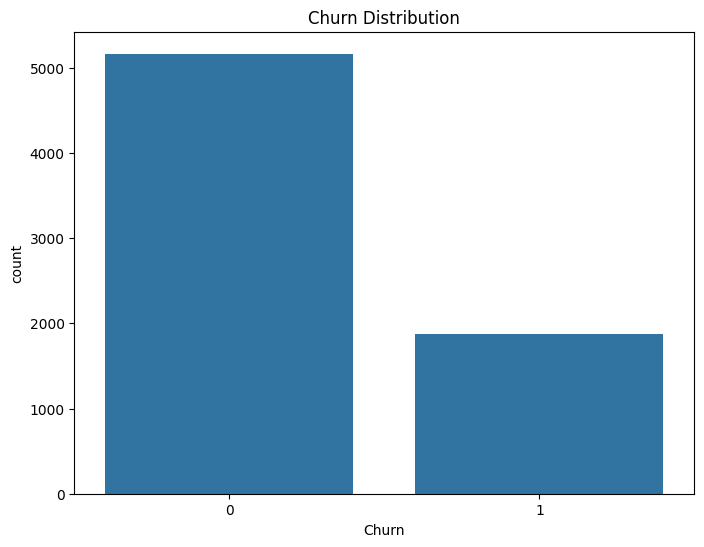

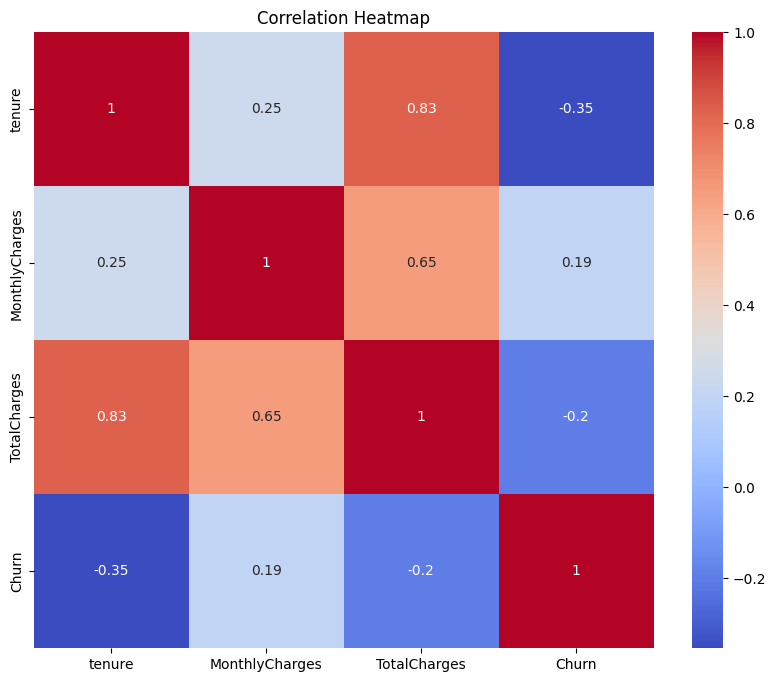

In [4]:
# Visualize class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Churn Distribution')
plt.show()

# Correlation heatmap for numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['Churn']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Interactive visualization of tenure vs monthly charges by churn
fig = px.scatter(df, x='tenure', y='MonthlyCharges', color='Churn',
                 title='Tenure vs Monthly Charges by Churn Status')
fig.show()

**Step 5: Handle Class Imbalance**

In [5]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
 Churn
0    5163
1    5163
Name: count, dtype: int64


**Step 6: Split and Scale the Data**

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Step 7: Model Training**

In [7]:
# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Train models
rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

**Step 8: Model Evaluation**

Random Forest Results:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1033
           1       0.85      0.86      0.85      1033

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066

ROC-AUC Score: 0.8533397870280737

XGBoost Results:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1033
           1       0.83      0.84      0.83      1033

    accuracy                           0.83      2066
   macro avg       0.83      0.83      0.83      2066
weighted avg       0.83      0.83      0.83      2066

ROC-AUC Score: 0.8330106485963213


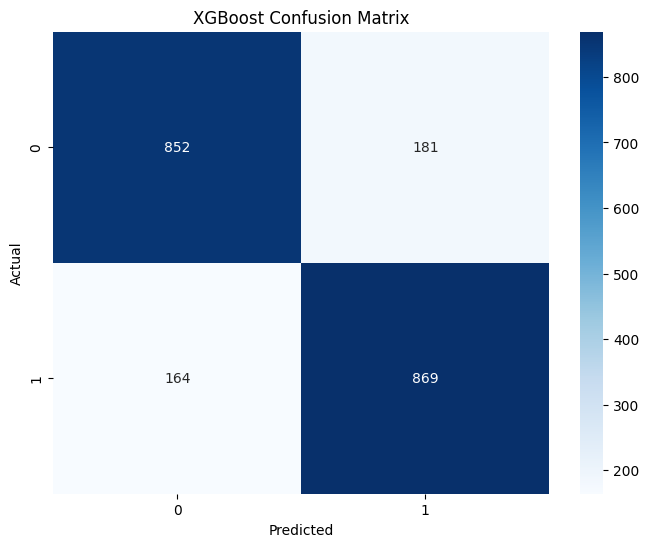

In [8]:
# Make predictions
rf_pred = rf_model.predict(X_test_scaled)
xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate Random Forest
print("Random Forest Results:")
print(classification_report(y_test, rf_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_pred))

# Evaluate XGBoost
print("\nXGBoost Results:")
print(classification_report(y_test, xgb_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, xgb_pred))

# Confusion Matrix for XGBoost
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Step 9: Feature Importance Analysis**

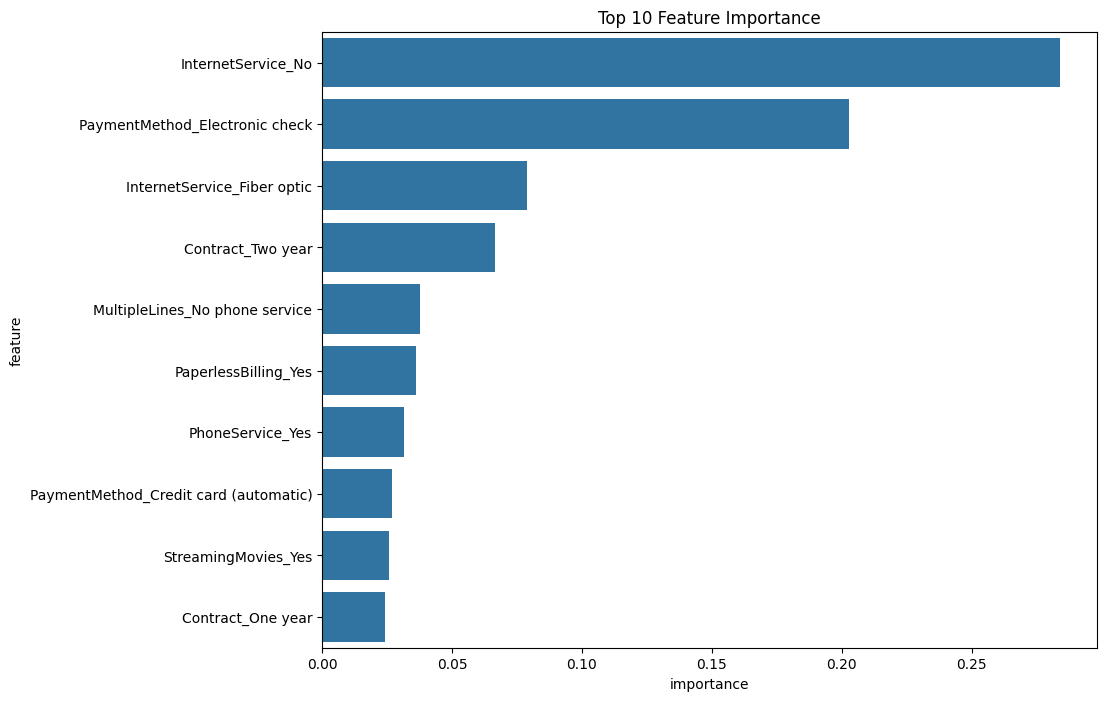

In [9]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.show()

**Step 10: Save the Model**

In [10]:
# Save the model
import joblib

# Create a dictionary with model and scaler
model_data = {
    'model': xgb_model,
    'scaler': scaler,
    'feature_names': list(X.columns)
}

# Save to Google Drive
joblib.dump(model_data, '/content/drive/MyDrive/churn_model.pkl')

print("Model saved successfully!")

Model saved successfully!


**Step 11: Create a Simple Prediction Function**

In [11]:
# Function to make predictions on new data
def predict_churn(customer_data):
    # Load model
    model_data = joblib.load('/content/drive/MyDrive/churn_model.pkl')
    model = model_data['model']
    scaler = model_data['scaler']
    feature_names = model_data['feature_names']

    # Ensure customer data has the right features
    customer_df = pd.DataFrame([customer_data])
    customer_df = customer_df.reindex(columns=feature_names, fill_value=0)

    # Scale the data
    customer_scaled = scaler.transform(customer_df)

    # Make prediction
    prediction = model.predict(customer_scaled)
    probability = model.predict_proba(customer_scaled)

    return prediction[0], probability[0][1]

# Example usage (you would need to prepare actual customer data)
# churn, probability = predict_churn(customer_data)
# print(f"Churn prediction: {churn}, Probability: {probability:.2f}")